# ENCH 470 Fall 2020 Lecture 12: Machine learning in cheminformatics

Original notebook by Andrea Volkamer, https://github.com/volkamerlab/TeachOpenCADD

## Imports 

In [1]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

import matplotlib.pyplot as plt

## Introduction to Classification

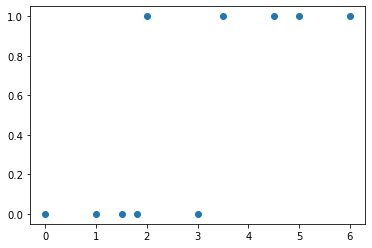

In [2]:
ym = np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1])
xm = np.array([0, 1, 1.5, 1.8, 2, 3, 3.5, 4.5, 5, 6])

plt.scatter(xm,ym)

In [3]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [4]:
print(xm)
xm = xm.reshape(-1,1)
print(xm)

[0.  1.  1.5 1.8 2.  3.  3.5 4.5 5.  6. ]
[[0. ]
 [1. ]
 [1.5]
 [1.8]
 [2. ]
 [3. ]
 [3.5]
 [4.5]
 [5. ]
 [6. ]]


In [5]:
print("xm = ", xm)

clf = LogisticRegression(random_state=0).fit(xm,ym)

print("The parameters are: ",clf.coef_)

ym_pred = clf.predict(xm)
#print(ym_pred)

ym_prob = clf.predict_proba(xm)
print(ym_prob)

score = clf.score(xm,ym)
print(score)

xm =  [[0. ]
 [1. ]
 [1.5]
 [1.8]
 [2. ]
 [3. ]
 [3.5]
 [4.5]
 [5. ]
 [6. ]]
The parameters are:  [[1.04275782]]
[[0.94561637 0.05438363]
 [0.85972598 0.14027402]
 [0.78442414 0.21557586]
 [0.72687196 0.27312804]
 [0.68357672 0.31642328]
 [0.43229352 0.56770648]
 [0.31133646 0.68866354]
 [0.13744958 0.86255042]
 [0.08643077 0.91356923]
 [0.03227131 0.96772869]]
0.8


**<font color=red> Problem: </font>** Plot the predictions of the classification model in high resolution! Show in a single figure:

1) the data (xm,ym) as points

2) a line for the predicted class from the model for x going from 0 to 6 in increments of 0.01

3) a line for the probability of class assignment for x going from 0 to 6 in increments of 0.01

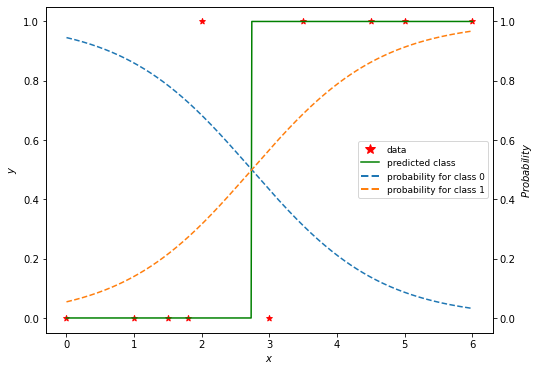

In [6]:
import matplotlib.lines as mlines
from matplotlib.lines import Line2D

fig, ax1 = plt.subplots(figsize = (8,6))
ax1.scatter(xm,ym,marker = '*',color='r')

x_a = np.arange(0,6.01,0.01)
x_a = x_a.reshape(-1,1)
y_pred_a = clf.predict(x_a)
ax1.plot(x_a,y_pred_a,'g-')
ax2 = ax1.twinx()
ax2.plot(x_a,clf.predict_proba(x_a),'--')
ax1.set_ylim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.set_ylabel('$Probability$')

legend_elements = [mlines.Line2D([], [], marker='*', linestyle='None', 
                                 color='r', label='data',
                                 markerfacecolor='r', markersize=10),
                   mlines.Line2D([], [], marker='None', linestyle='-', 
                                 color='g', label='predicted class',
                                 markerfacecolor='none', markersize=10),
                   mlines.Line2D([], [], marker='None', linestyle='--', 
                                 color='#1f77b4', label='probability for class 0', lw=2),
                   mlines.Line2D([], [], marker='None', linestyle='--', 
                                 color='#ff7f0e', label='probability for class 1', lw=2),
                  ]

ax1.legend(handles=legend_elements,loc='right',prop={'size':9})

**<font color=orange> Extra Credit Problem: </font>** We can look up the fitted coefficients in the model using `clf.coef_`. Can you use that parameter in a logistic function to reproduce any of the curves above?

[[1.04275782]]
[-2.85577372]


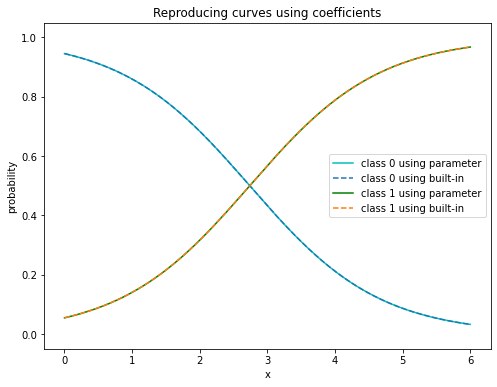

In [7]:
print(clf.coef_)
print(clf.intercept_)
prob = 1/(1+np.exp(clf.coef_*x_a+clf.intercept_))
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(x_a,prob,'c')
ax.plot(x_a,clf.predict_proba(x_a)[:,0],'--')
ax.plot(x_a,1-prob,'g')
ax.plot(x_a,clf.predict_proba(x_a)[:,1],'--')
ax.set_xlabel('x')
ax.set_ylabel('probability')
ax.set_title('Reproducing curves using coefficients')
ax.set_ylim([-0.05,1.05])
ax.legend(['class 0 using parameter','class 0 using built-in',
          'class 1 using parameter','class 1 using built-in'])

## Classification of EGFR Inhibitors
### ChEMBL

* Largest freely available source for molecules and affinities
* https://www.ebi.ac.uk/chembl/

### EGFR - Epidermal Growth Factor Receptor

We're going to work with molecules developed to target the EGFR: https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor

#### Import the data for active and inactive molecules into dataframes

In [8]:
df_act = pd.read_csv('RDKitdata/Chembl_EGFR_actives_ML.csv', delimiter=',', header=0)
df_inact = pd.read_csv('RDKitdata/Chembl_EGFR_inactives_ML.csv', delimiter=',', header=0)

In [9]:
print (len(df_act), len(df_inact))

100 100


In [10]:
df_act.head(10)

,canonical_smiles,molecule_chembl_id
0,COc1ccc(NC(=O)c2ccc(cc2)N(CCCl)CCCl)cc1,CHEMBL589588
1,N(c1ccc2[nH]ccc2c1)c3ncnc4cc(sc34)c5ccccc5,CHEMBL76432
2,CS(=O)(=O)CCNCCCCOc1ccc2ncnc(Nc3ccc(F)c(Cl)c3)...,CHEMBL460731
3,NC(=O)C1CCN(Cc2ccc(cc2)c3cc4nccc(Nc5ccc6[nH]cc...,CHEMBL431977
4,CC(C)(CO)NCc1ccc(cc1)c2cc3ncnc(Nc4ccc5[nH]ccc5...,CHEMBL308498
5,Brc1cccc(Nc2ncnc3cnc(cc23)S(=O)(=O)C=C)c1,CHEMBL336264
6,CCN(CC)CC(O)CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,CHEMBL433520
7,CN(C)CCCOC(=O)\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br...,CHEMBL140561
8,CN(C)CCCNC(=O)\C=C\C(=O)N(C)c1cc2c(Nc3cccc(Br)...,CHEMBL136102
9,Cc1cc(C)c(\C=C\2/C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4...,CHEMBL68920


#### Get SMILES in list

In [11]:
act_smiles = df_act['canonical_smiles'].tolist()
inact_smiles = df_inact['canonical_smiles'].tolist()

#### Make lists of molecule objects

In [12]:
#mols_act = []
#for i in act_smiles:
#    mols_act += [Chem.MolFromSmiles(i)]

# new_list = [operation or function on x for x in old_list ]

mols_act = [Chem.MolFromSmiles(i) for i in act_smiles]
mols_inact = [Chem.MolFromSmiles(i) for i in inact_smiles]

## Visualizing the data

Let's see what we got here in this dataset! Remember those descriptors we calculated last time? Let's get those, and add them to our dataframes

In [13]:
HeavyAtomCount_act = [Descriptors.HeavyAtomCount(x) for x in mols_act]
HeavyAtomCount_inact = [Descriptors.HeavyAtomCount(x) for x in mols_inact]

MolLogP_act = [Descriptors.MolLogP(x) for x in mols_act]
MolLogP_inact = [Descriptors.MolLogP(x) for x in mols_inact]

df_act['HeavyAtomCount'] = HeavyAtomCount_act
df_inact['HeavyAtomCount'] = HeavyAtomCount_inact

df_act['MolLogP'] = MolLogP_act
df_inact['MolLogP'] = MolLogP_inact

#df_act.head(10)

**<font color=red> Problem: </font>** Look up 3 more descriptors available under the `Descriptors` library in RDKit, and add them to the dataframes. You can find a list of these on [this page](https://www.rdkit.org/docs/GettingStartedInPython.html).

In [14]:
NumHAcceptors_act = [Descriptors.NumHAcceptors(x) for x in mols_act]
NumHAcceptors_inact = [Descriptors.NumHAcceptors(x) for x in mols_inact]
df_act['NumHAcceptors'] = NumHAcceptors_act
df_inact['NumHAcceptors'] = NumHAcceptors_inact

NumHDonors_act = [Descriptors.NumHDonors(x) for x in mols_act]
NumHDonors_inact = [Descriptors.NumHDonors(x) for x in mols_inact]
df_act['NumHDonors'] = NumHDonors_act
df_inact['NumHDonors'] = NumHDonors_inact

RingCount_act = [Descriptors.RingCount(x) for x in mols_act]
RingCount_inact = [Descriptors.RingCount(x) for x in mols_inact]
df_act['RingCount'] = RingCount_act
df_inact['RingCount'] = RingCount_inact

display(df_act)
display(df_inact)

,canonical_smiles,molecule_chembl_id,HeavyAtomCount,MolLogP,NumHAcceptors,NumHDonors,RingCount
0,COc1ccc(NC(=O)c2ccc(cc2)N(CCCl)CCCl)cc1,CHEMBL589588,24,4.23150,3,1,2
1,N(c1ccc2[nH]ccc2c1)c3ncnc4cc(sc34)c5ccccc5,CHEMBL76432,25,5.58320,4,2,5
2,CS(=O)(=O)CCNCCCCOc1ccc2ncnc(Nc3ccc(F)c(Cl)c3)...,CHEMBL460731,31,3.95910,7,2,3
3,NC(=O)C1CCN(Cc2ccc(cc2)c3cc4nccc(Nc5ccc6[nH]cc...,CHEMBL431977,35,5.88550,5,3,6
4,CC(C)(CO)NCc1ccc(cc1)c2cc3ncnc(Nc4ccc5[nH]ccc5...,CHEMBL308498,32,5.44370,6,4,5
...,...,...,...,...,...,...,...
95,CCOC(=O)c1cn2ncnc(Nc3ccc4[nH]ncc4c3)c2c1CC,CHEMBL372112,26,3.08830,7,2,4
96,COc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3)c12,CHEMBL194389,28,5.00940,6,1,4
97,CC1CNCCN(Cc2ccn3ncnc(Nc4ccc5c(cnn5Cc6cccc(F)c6...,CHEMBL398793,36,4.05130,8,2,6
98,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4ccccn4)c(Cl)c3)c2...,CHEMBL180022,40,5.93248,8,2,4


,canonical_smiles,molecule_chembl_id,HeavyAtomCount,MolLogP,NumHAcceptors,NumHDonors,RingCount
0,ClCCN(CCCl)c1ccc(cc1)C(=O)NC2CCCC2,CHEMBL589503,21,3.64300,2,1,2
1,ClCCN(CCCl)c1ccc(cc1)C(=O)Nc2ccccc2Cl,CHEMBL592710,23,4.87630,2,1,2
2,CCCN(CCC)C(=O)c1ccc(cc1)N(CCCl)CCCl,CHEMBL602645,22,4.23280,2,0,1
3,CCCCCCCCCCCCNC(=O)c1ccc(cc1)N(CCCl)CCCl,CHEMBL590081,28,6.62130,2,1,1
4,C[C@H](Nc1nccc(n1)c2c(nc(C3CCNCC3)n2C)c4cccc(c...,CHEMBL305178,37,6.20300,6,2,5
...,...,...,...,...,...,...,...
95,CC(=O)OC(Cc1c(SSc2[nH]c3ccccc3c2CC(OC(=O)C)C(=...,CHEMBL348146,52,7.02980,8,4,6
96,OC(=O)CCc1c(SSc2[nH]c3ccccc3c2CCC(=O)O)[nH]c4c...,CHEMBL79704,30,5.48300,4,4,4
97,COc1cc(\C=C(/C#N)\C(=O)N)cc(CSc2ccccc2NC(=O)C)c1O,CHEMBL115895,28,3.04378,6,3,2
98,COc1cc(\C=C(/C#N)\C(=O)N)cc(CSCCCC(=O)O)c1O,CHEMBL326044,24,1.89108,6,3,1


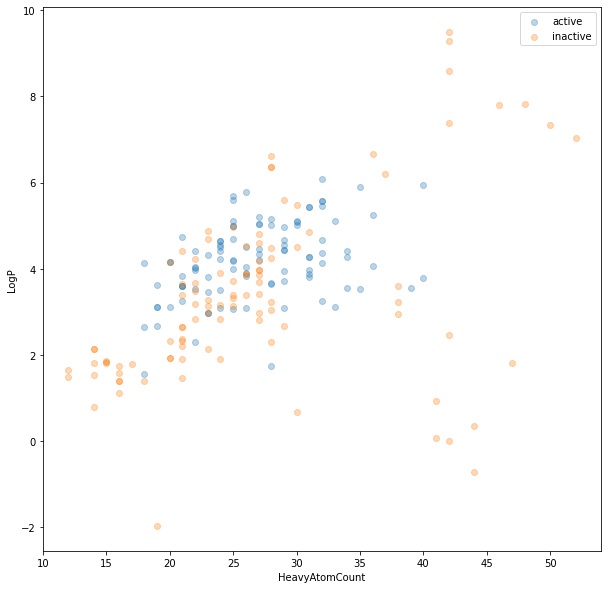

In [15]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(df_act['HeavyAtomCount'],df_act['MolLogP'],alpha=0.3)
ax.scatter(df_inact['HeavyAtomCount'],df_inact['MolLogP'],alpha=0.3)
ax.set_ylabel('LogP')
ax.set_xlabel('HeavyAtomCount')
ax.legend(['active','inactive'])

#### Calculate fingerprints

By default the RDKit generates Morgan fingerprints with radius 2 (MFP2)

In [16]:
# Fingerprints for active molecules
fps_act = rdFingerprintGenerator.GetFPs(mols_act)

# Fingerprints for inactive molecules
fps_inact = rdFingerprintGenerator.GetFPs(mols_inact)

# Concatenate fingerprints
fps = fps_act + fps_inact
len(fps)

200

#### Assign classes to each molecule

In [17]:
# 'Active' = 1
y_act = np.ones(len(fps_act))

# 'Inactive' = 0
y_inact = np.zeros(len(fps_inact))

# Classifier
y = np.concatenate([y_act, y_inact])
len(y)

200

## Logistic regression on EGFR dataset

Now, **using the fingerprints as our features** let's fit a logistic regression model!


### Split data in train and test set

In [18]:
from sklearn.model_selection import train_test_split

# 20% for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(fps, y, test_size=0.20)

### Train the model


In [19]:
clf = LogisticRegression(random_state=0).fit(X_train,y_train)

print("The parameters are: ", clf.coef_)

#plt.scatter(np.arange(0,2048),clf.coef_)

#print(y_train)

y_train_pred = clf.predict(X_train)
print(y_train_pred)

y_train_prob = clf.predict_proba(X_train)

score = clf.score(X_train,y_train)
print(score)

The parameters are:  [[ 0.         -0.0912202   0.01132326 ...  0.01677969  0.01534855
  -0.10203004]]
[0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.]
1.0


### Test performance of the model

In [20]:
y_test_pred = clf.predict(X_test)
#print(y_test_pred)

y_test_prob = clf.predict_proba(X_test)
#print(y_test_prob)

score = clf.score(X_test,y_test)
print(score)


import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test,y_test_pred)
print(accuracy)

# The confusion matrix shows false positives and false negatives
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test,y_test_pred))

0.9
0.9
Confusion matrix:
[[21  2]
 [ 2 15]]


## Logistic regression predictions for FDA approved drugs

In [21]:
df = pd.read_csv('RDKitdata/EGFR-course.csv', delimiter=',', names=['Smiles', 'Name'], header=None)
df

,Smiles,Name
0,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,Gefitinib
1,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,Erlotinib
2,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,Lapatinib
3,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...,Afatinib
4,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,Osimertinib


In [22]:
for tmp_smiles in df.Smiles.values:
    mol = Chem.MolFromSmiles(tmp_smiles)
    fps1 = rdFingerprintGenerator.GetFPs([mol])
    
    y_pred = clf.predict(fps1)
    y_prob = clf.predict_proba(fps1)
    print(y_pred, y_prob)


[1.] [[0.01497535 0.98502465]]
[1.] [[0.0078321 0.9921679]]
[1.] [[0.01199711 0.98800289]]
[1.] [[0.0031623 0.9968377]]
[0.] [[0.87577124 0.12422876]]


**<font color=red> Problem: </font>** Plot training accuracy vs. training set size from 10% in training set to 100% in training set. Plot test accuracy vs. training set size from 10% in training set to 100% in training set.

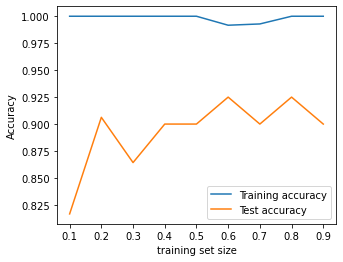

In [23]:
train_size = np.arange(0.10,1,0.1)
score_train = np.zeros(len(train_size))
score_test = np.zeros(len(train_size))
for i in range(len(train_size)):
    X_train, X_test, y_train, y_test = train_test_split(fps, y, test_size=1-train_size[i])
    
    clf = LogisticRegression(random_state=0).fit(X_train,y_train)        

    score_train[i] = clf.score(X_train,y_train)
    score_test[i] = clf.score(X_test,y_test)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(train_size,score_train)
ax.plot(train_size,score_test)
ax.set_xlabel('training set size')
ax.set_ylabel('Accuracy')
ax.legend(['Training accuracy','Test accuracy'])

**<font color=red> Problem: </font>** Examine the Tanimoto similarity of the active and inactive molecules to each of the 5 FDA-approved molecules using the Morgan fingerprints of radius 2. Think of a way to visualize this, and share your findings.

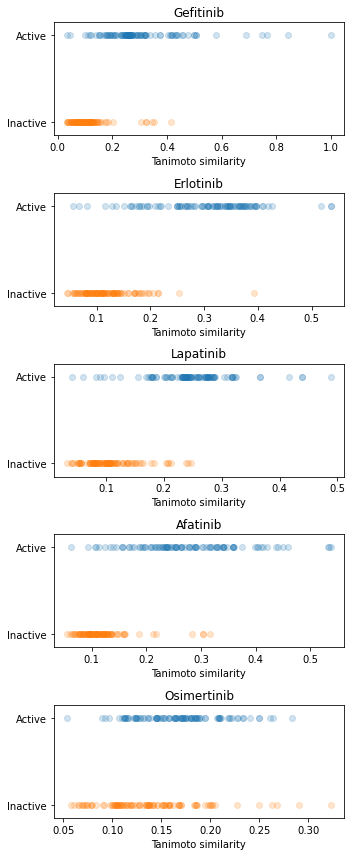

In [24]:
from rdkit import DataStructs

Act_list = []
Inact_list = []
for tmp_smiles in df.Smiles.values:
    mol = Chem.MolFromSmiles(tmp_smiles)
    fps_drug = rdFingerprintGenerator.GetFPs([mol])

    Tan_sim_act = np.zeros(len(fps_act))
    for i in range(len(fps_act)):
        Tan_sim_act[i] = DataStructs.TanimotoSimilarity(fps_drug[0],fps_act[i])
    Act_list.append(Tan_sim_act)
    
    Tan_sim_inact = np.zeros(len(fps_inact))
    for j in range(len(fps_inact)):
        Tan_sim_inact[j] = DataStructs.TanimotoSimilarity(fps_drug[0],fps_inact[j])
    Inact_list.append(Tan_sim_inact)

drug_name = list(df['Name'])

fig,ax=plt.subplots(5,1,figsize=(5,12))
for i in range(len(drug_name)):
    ax[i].scatter(Act_list[i],np.ones(len(Act_list[i])),alpha=0.2)
    ax[i].scatter(Inact_list[i],np.zeros(len(Inact_list[i])),alpha=0.2)
    ax[i].set_xlabel('Tanimoto similarity')
    ax[i].set_yticks(np.arange(2))
    ax[i].set_ylim([-0.15,1.15])
    ax[i].set_yticklabels(('Inactive','Active'))
    ax[i].set_title(drug_name[i])
    
fig.tight_layout()

**<font color=Green> Answer: </font>** : Active molecules have high Tanimoto similarity values to the
FDA drugs except Osimertinib. 